# 🎂 Segmind Challenge : Prediction of Sales of each Store🎂

## TO DO:

> Predict store sales of a store using the given dataset.

## Data:
> Dataset Given

* The dataset consists of 4 CSV files:
* TRAIN.csv : (./dataset/TRAIN.csv)
* TEST.csv: (./dataset/TEST.csv)
* store.csv - additional information regarding the stores: (./dataset/store.csv)

## Evaluate:
* Time-series prediction problem.
* Sales has direct correlation to OPEN or not

## Features:
> From Test data

* Store: Store number
* DayOfWeek: Day (out of 7) per week
* Date: DD-MM-YYYY format
* Open: 1 for open, 0 for close
* Promo: 0 or 1 
* StateHoliday: 0, a, b, c (0 or store type)
* SchoolHoliday: 0 or 1

## 🤳Imports

In [15]:
# Essentials
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from dateutil.parser import parse
from math import ceil
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import ElasticNet, Lasso, SGDRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pprint import pprint

import pickle

## 💚Inputs

In [14]:
# Store data
def import_store():
    storedf = pd.read_csv('./dataset/store.csv')
    return storedf
# Sales data
def import_data(x):
    df = pd.read_csv('./dataset/'+x+'.csv')
    return df

## 💌Total preprocessing

In [3]:
# Store attributes
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months_with_store = ['Store','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
num_attribs = ["CompetitionDistance",
               "CompetitionOpenSinceMonth",
               "CompetitionOpenSinceYear",
               "Promo2SinceWeek",
               "Promo2SinceYear"]
# scale_attribs = ["CompetitionDistance"]
obj_attribs = ["StoreType", "Assortment"]

In [4]:
# Store Pipelines

# cd_pipeline_median = Pipeline([
#     ("imputer", SimpleImputer(strategy='median')),
#     ("stdscale", StandardScaler())
# ])

# cd_pipeline_mean = Pipeline([
#     ("imputer", SimpleImputer(strategy='mean')),
#     ("stdscale", StandardScaler())
# ])

# cd_pipeline_mode = Pipeline([
#     ("imputer", SimpleImputer(strategy='most_frequent')),
#     ("stdscale", StandardScaler())
# ])

full_pipeline_median = ColumnTransformer([
    ("num", SimpleImputer(strategy='median'), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

full_pipeline_mean = ColumnTransformer([
    ("num", SimpleImputer(strategy='mean'), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

full_pipeline_mode = ColumnTransformer([
    ("num", SimpleImputer(strategy='most_frequent'), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

In [5]:
# Sore Preprocessing

def divide_promointerval():
    '''
    1. Fillna with '0' in PROMOINTERVAL
    2. Dividing PromoInterval into months and applying custom one hot encoding
    4. Drop PROMOINTERVAL
    ----------
    PARAMETERS
    ----------
    NA
    -------
    RETURNS
    -------    
    test: DF after divinding the Promointerval into months
    '''
    store['PromoInterval'].fillna(value='0', inplace=True)
    test = pd.DataFrame(data=store.Store, columns=months_with_store)
    for month in months:
        test[month] = np.where(store["PromoInterval"].str.contains(month), 1, 0)
    if 'PromoInterval' in store.columns:    
        store.drop('PromoInterval', inplace=True, axis=1)    
    return test

def drop_store_columns():
    '''
    Dropping columns after preprocessing.
    '''
    for attri in num_attribs:
        if attri in store.columns:
            store.drop(attri, inplace=True, axis=1)
    for attri in obj_attribs:
        if attri in store.columns:
            store.drop(attri, inplace=True, axis=1)         

In [8]:
# Store transformation
store = import_store()
store_tranformed = full_pipeline_median.fit_transform(store)
drop_store_columns()
store_prepared = pd.DataFrame(data=store_tranformed, columns=(num_attribs+obj_attribs), index=store.index)
store = store.join(store_prepared)
month_df = divide_promointerval()
store_df = pd.merge(left=store, right=month_df, on='Store')

In [9]:
# Data Preprocessing
def week_of_month(tgtdate):
    date = parse(tgtdate)
    first_day = date.replace(day=1)

    day_of_month = date.day

    if(first_day.weekday() == 6):
        adjusted_dom = (1 + first_day.weekday()) / 7
    else:
        adjusted_dom = day_of_month + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

def change_tf(true_false):
    if true_false == True:
        return 1
    else:
        return 0

def date_preproccesing():
    train_df['year'] = pd.DatetimeIndex(train_df['Date']).year
    train_df['month'] = pd.DatetimeIndex(train_df['Date']).month
    train_df['quarter'] = pd.DatetimeIndex(train_df['Date']).quarter
    train_df['dayofyear'] = pd.DatetimeIndex(train_df['Date']).dayofyear
    train_df['weekofyear'] = pd.DatetimeIndex(train_df['Date']).weekofyear
    train_df['week'] = pd.DatetimeIndex(train_df['Date']).week
    train_df['is_month_start'] = pd.DatetimeIndex(train_df['Date']).is_month_start
    train_df['is_month_end'] = pd.DatetimeIndex(train_df['Date']).is_month_end
    train_df['is_year_end'] = pd.DatetimeIndex(train_df['Date']).is_year_end
    train_df['is_year_start'] = pd.DatetimeIndex(train_df['Date']).is_year_start
    train_df["StateHoliday"] = train_df["StateHoliday"].apply(lambda x: str(x))
    train_df["WeekOfMonth"] = train_df["Date"].apply(week_of_month)
    train_df["is_month_start"] = train_df["is_month_start"].apply(lambda x: change_tf(x))
    train_df["is_month_end"] = train_df["is_month_end"].apply(lambda x: change_tf(x))
    train_df["is_year_end"] = train_df["is_year_end"].apply(lambda x: change_tf(x))
    train_df["is_year_start"] = train_df["is_year_start"].apply(lambda x: change_tf(x))

def cat_transformation(x):
    if 'train' in x:
        train_df['StateHolidayCat'] = labelencoder.fit_transform(train_df['StateHoliday'])
    else:
        train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])

def drop_data_columns():
    if 'Date' in train_df.columns:
        train_df.drop('Date', inplace=True, axis=1)
    if 'StateHoliday' in train_df.columns:
        train_df.drop('StateHoliday', axis=1, inplace=True)
    if 'Customers' in train_df.columns:
        train_df.drop('Customers', axis=1, inplace=True)

In [10]:
labelencoder = LabelEncoder()

In [28]:
# Data transformation
# labelencoder = LabelEncoder()
train_or_test = 'test' #'test' 'train'
train_df = import_data(train_or_test)
date_preproccesing()
if 'train' in train_or_test:
    labelencoder.fit(train_df['StateHoliday'])
    train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
#     labelencoder.fit_transform(train_df['StateHoliday'])
else:
    train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
# train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
# cat_transformation(train_or_test)
drop_data_columns()

<ipython-input-9-1c317fd3e691>:26: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['weekofyear'] = pd.DatetimeIndex(train_df['Date']).weekofyear
<ipython-input-9-1c317fd3e691>:27: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['week'] = pd.DatetimeIndex(train_df['Date']).week


In [29]:
# Final_df
# final_df = pd.merge(left=train_df, right=store_df, on='Store')
final_df = pd.merge(train_df, store_df, how='left', left_on='Store', right_on='Store')
# final_df.drop('Store', axis=1, inplace=True)

In [30]:
final_df.columns

Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'year', 'month',
       'quarter', 'dayofyear', 'weekofyear', 'week', 'is_month_start',
       'is_month_end', 'is_year_end', 'is_year_start', 'WeekOfMonth',
       'StateHolidayCat', 'Promo2', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceWeek', 'Promo2SinceYear', 'StoreType', 'Assortment', 'Jan',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec'],
      dtype='object')

## 🎁Modelling

In [19]:
# Splitting the data
X = final_df.drop('Sales', axis=1)
y = final_df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
"""
from sklearn.linear_model import ElasticNet, Lasso, SGDRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor
import xgboost

models = {"ElasticNet" : ElasticNet(),
          "Lasso" : Lasso(),
          "SGDRegressor" : SGDRegressor(),
          "BayesianRidge" : BayesianRidge(),
          "DecisionTreeRegressor" : DecisionTreeRegressor(),
          "SVR" : SVR()
         }
"""

en_model = ElasticNet()
lasso = Lasso()
SGD = SGDRegressor()
BR = BayesianRidge()
DTR = DecisionTreeRegressor()
# SVR = SVR()
MLP = MLPRegressor(max_iter=100,verbose=True)
RFR = RandomForestRegressor(verbose=2)
xgb = xgboost.XGBRegressor(verbosity=2)

models = {
    "MLPRegressor": MLP,
    "RandomForestRegressor": RFR,
    "XGBRegressor": xgb
}


In [13]:
def fit_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        print('Model Start!')
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
        print('Model End!')
    return model_scores

In [29]:
#model_scores = fit_score(models, X_train, X_test, y_train, y_test)
model_scores.update(fit_score(models, X_train, X_test, y_train, y_test))

Model Start!
Iteration 1, loss = 7721650.45073706
Iteration 2, loss = 7074140.20634800
Iteration 3, loss = 5996807.75254129
Iteration 4, loss = 5029296.57321461
Iteration 5, loss = 4571825.39954207
Iteration 6, loss = 4314751.04225465
Iteration 7, loss = 4106602.14998017
Iteration 8, loss = 3958098.09794809
Iteration 9, loss = 3825470.57778907
Iteration 10, loss = 3720868.66667989
Iteration 11, loss = 3640254.10326866
Iteration 12, loss = 3571773.92006500
Iteration 13, loss = 3515558.79538427
Iteration 14, loss = 3458240.61117898
Iteration 15, loss = 3415064.18445935
Iteration 16, loss = 3386019.34981275
Iteration 17, loss = 3354930.61525069
Iteration 18, loss = 3334383.44521876
Iteration 19, loss = 3316293.93764410
Iteration 20, loss = 3302711.93049922
Iteration 21, loss = 3285751.38218157
Iteration 22, loss = 3283565.61674669
Iteration 23, loss = 3266745.17847074
Iteration 24, loss = 3259539.59354565
Iteration 25, loss = 3246214.02095140
Iteration 26, loss = 3237154.93285000
Iteratio

C:\Users\rishi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Model End!
Model Start!
building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.0s finished


Model End!
Model Start!
[00:36:33] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:36:33] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:36:33] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:36:33] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:36:34] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:36:34] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:36:34] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:36:34] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:36:34] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 64 

[00:36:45] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:36:45] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[00:36:45] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:36:45] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:36:46] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[00:36:46] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:36:46] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:36:46] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:36:46] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 

In [30]:
model_scores

{'ElasticNet': 0.3718063611574982,
 'Lasso': 0.5667788895225012,
 'BayesianRidge': 0.5668651374659268,
 'DecisionTreeRegressor': 0.9048888336533956,
 'MLPRegressor': 0.6009451724128054,
 'RandomForestRegressor': 0.9458227294639168,
 'XGBRegressor': 0.9052904547244324}

<AxesSubplot:>

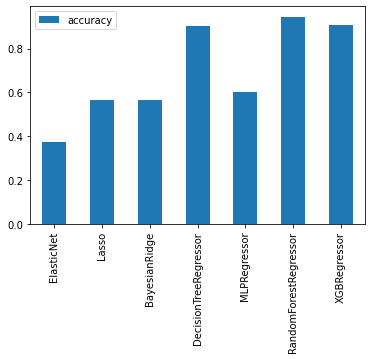

In [31]:
model_compare = pd.DataFrame(model_scores,index=["accuracy"])
model_compare.T.plot.bar()

In [13]:
# Testing RandomFreeRegressor

# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators = [100,200,50,150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 50, 150]}


In [16]:
# New Randoms
random_grid = {'n_estimators': [200, 160, 150],
               'max_features': ['auto'],
               'max_depth': [70,80,90,100,110,None],
               'min_samples_split': [5],
               'min_samples_leaf': [2],
               'bootstrap': [False]}
pprint(random_grid)


{'bootstrap': [False],
 'max_depth': [70, 80, 90, 100, 110, None],
 'max_features': ['auto'],
 'min_samples_leaf': [2],
 'min_samples_split': [5],
 'n_estimators': [200, 160, 150]}


In [17]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = RFR,
                               param_distributions = random_grid,
                               n_iter = 5, cv = 3, verbose=2, n_jobs=5,
                               scoring='neg_root_mean_squared_error',
                               random_state=42)

In [ ]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [17]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=90, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=150, verbose=2)

In [18]:
rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

In [23]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=80, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=150, verbose=2)

In [20]:
RFR = RandomForestRegressor(n_estimators=150, max_depth=80, min_samples_leaf=2, min_samples_split=5, bootstrap=False, verbose=2)
RFR.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 12.8min finished


RandomForestRegressor(bootstrap=False, max_depth=80, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=150, verbose=2)

In [22]:
pickle.dump(RFR, open("RFModel2.pkl","wb"))

In [2]:
load_model_random_rf = pickle.load(open('RFModel2.pkl','rb'))

In [3]:
load_model_random_rf.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state',
 'ccp_alpha')

In [6]:
columns = ['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'year', 'month',
       'quarter', 'dayofyear', 'weekofyear', 'week', 'is_month_start',
       'is_month_end', 'is_year_end', 'is_year_start', 'WeekOfMonth',
       'StateHolidayCat', 'Promo2', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceWeek', 'Promo2SinceYear', 'StoreType', 'Assortment', 'Jan',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec']

<AxesSubplot:>

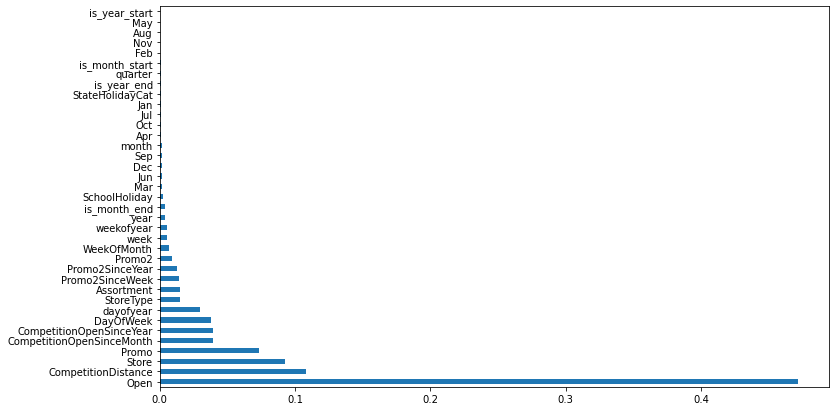

In [13]:
(pd.Series(load_model_random_rf.feature_importances_, index=columns)
 .nlargest(50)
   .plot(kind='barh', figsize=(12,7))) 

In [26]:
load_model_random_rf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.9s finished


0.9205670581985987

In [27]:
mean_squared_error(y_test, load_model_random_rf.predict(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.8s finished


1222812.058119685

In [31]:
# Testing
results = load_model_random_rf.predict(final_df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   14.0s finished


In [32]:
df_results = pd.DataFrame(results, index = None)
#Remove all negative
df_results[df_results < 0] = 0
df_results["Index"]=range(0, len(df_results))
df_results.columns=["Sales","Index"]

columns_titles = ["Index","Sales"]
df_results=df_results.reindex(columns=columns_titles)
#Apply Up on the Sales column
df_results['Sales'] = df_results['Sales'].apply(np.ceil)
print(df_results.info())
print(df_results.head())
df_results.to_csv("outputm4.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305163 entries, 0 to 305162
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Index   305163 non-null  int32  
 1   Sales   305163 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 3.5 MB
None
   Index   Sales
0      0     0.0
1      1  3436.0
2      2  5752.0
3      3  3976.0
4      4  7187.0
